In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import sqlalchemy as sa

# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', df_Nest.shape[0]+1)
# pd.set_option('display.min_rows', 100)


Destination dataframes:
1. איתור והעתקה
2. הפקדה
3. ביקורת תטולה
4. פתיחת קן


In [2]:
## import data

driver = "{Microsoft Access Driver (*.mdb, *.accdb)}"
db_path = "C:/Users/michalsh/Downloads/TurtlesDB_be.mdb"
engine_string = 'DRIVER=%s;DBQ=%s;' % (driver,db_path)
engine_url = sa.engine.URL.create(
    "access+pyodbc",
    query={"odbc_connect": engine_string})

engine = sa.create_engine(engine_url)

table_names=['AcHatch','AcCrawl', 'Activities', 'Clutches', 'ClutchToNest','Contact',
      'ContactPosition', 'Crawl', 'CrawlContact', 'CrawlPredator', 'Hatcheries',
      'Immerging', 'Location', 'Nest', 'Organization', 'Specie', 'TurtleEvent', 'Regions']

for table_name in table_names:
    query ="SELECT * FROM %s" %(table_name)
    df = pd.read_sql(query, engine)
    globals()['df_%s' % table_name] = df


clean Contact null names and create a full name column

In [3]:
### orginizing and cleaning Contacts dataframe

### --- Generate FullName column without null values.

df_Contact['FullName']= df_Contact['ContactFname'].fillna('') + ' ' + df_Contact['ContactLname'].fillna('')
df_Contacts_clean = df_Contact[['ContactId', 'ContactIDNum', 'ContactPosition', 'BeachSurveyor',
       'NestRelocator', 'NestExcavator', 'ContactGender', 'ContactE-mail',
       'ContactNotes','FullName']]


### test- check for nan FullNames:
if df_Contacts_clean['FullName'].isnull().values.any():
    print ('there are null values!')


### --- Adding position and organization to contacts

df_ContactPosition_Organization = pd.merge(df_ContactPosition, df_Organization, left_on='Organization', right_on='OrganizationID', how='left')
df_Contacts_Position_Organization = pd.merge(df_Contacts_clean, df_ContactPosition_Organization, left_on='ContactPosition', right_on='PositionID', how='left')


### re assigning to original variable:
df_Contact = df_Contacts_Position_Organization

In [4]:
### location df

df_Regions_clean = df_Regions.drop(['RegionSite', 'RegionNorth', 'RegionSouth', 'RegionEast', 'RegionWest'], axis=1)
df_Location_Regions = pd.merge(df_Location, df_Regions_clean, left_on='Region', right_on='RegionId', how='left')
# print(df_Location.shape[0] == df_Location_Regions.shape[0])

### re assigning to original variable:
df_Location = df_Location_Regions

In [5]:
### Crawls df
# 1 --- adding species, location to crawls ---

df_Crawl_clean = df_Crawl.drop(['RegionalCrawlID'], axis=1)
df_Specie_clean = df_Specie.drop(['SpeciePic'], axis=1)
df_Crawl_Specie = pd.merge(df_Crawl_clean, df_Specie_clean, left_on='SpecieID', right_on='SpecieId',how='left')
df_Crawl_Specie_Location = pd.merge(df_Crawl_Specie, df_Location, left_on= 'Location', right_on='LocationID', how='left')






In [6]:
# 2 --- adding contacts info ---


def GetContact(crawlcontact_id):
    contact = df_Contact.loc[df_Contact['ContactId'] == crawlcontact_id]
    # contact_name = contact['FullName'].item()
    return contact


df_Crawl_Specie_Location_Contacts = df_Crawl_Specie_Location

crawl_ids_counter = Counter(df_CrawlContact.CrawlID)
for crawl_id in crawl_ids_counter.keys():
    more_contacts_str =''
    contacts_ids=df_CrawlContact.loc[df_CrawlContact.CrawlID == crawl_id]
    contact_list = []

    for crawlcontact_id in contacts_ids['ContactID']:
        contact = df_Contact.loc[df_Contact['ContactId'] == crawlcontact_id]
        contact_name = contact['FullName'].item()
        contact_list.append(contact_name)

    main_contact_name = contact_list[0]
    if len(contact_list)>0:
        more_contacts_str = ', '.join(contact_list[1:])

    updating_index = np.where(df_Crawl_Specie_Location_Contacts['CrawlID']==crawl_id)[0][0]
    df_Crawl_Specie_Location_Contacts.at[updating_index,'other_observers_names'] = more_contacts_str
    df_Crawl_Specie_Location_Contacts.at[updating_index,'main_observer_name'] = main_contact_name
    df_Crawl_Specie_Location_Contacts.at[updating_index, 'CrawlID']

    contacts_ids_list = []
    for i in contacts_ids['ContactID']:
        contacts_ids_list.append(str(i))
    contacts_ids_str = ', '.join(contacts_ids_list)
    df_Crawl_Specie_Location_Contacts.at[updating_index, 'contacts_ids'] = contacts_ids_str

#     print('new CrawlID: ', df_Crawl_Specie_Location_Contacts.at[updating_index, 'CrawlID'])
#     print('new main_observer_name: ',df_Crawl_Specie_Location_Contacts.at[updating_index, 'main_observer_name'])
#     print('new other_observers_names: ',df_Crawl_Specie_Location_Contacts.at[updating_index, 'other_observers_names'])
#     print('new contacts_ids: ',df_Crawl_Specie_Location_Contacts.at[updating_index, 'contacts_ids'])
#     print('-------------------------')
#     print('')



### re assigning to original variable:
# df_Crawl = df_Crawl_Specie_Location

In [7]:
# 3 --- adding predators ---


df_Crawl_Specie_Location_Contacts_Predators = df_Crawl_Specie_Location_Contacts
crawl_predators_ids_counter = Counter(df_CrawlPredator.CrawlID)

for crawl_id in crawl_predators_ids_counter.keys():
    if not crawl_id >0:
        print('is a null values', crawl_id)
    else:
        crawl_predators = df_CrawlPredator.loc[df_CrawlPredator.CrawlID == crawl_id]
        crawl_predators_list = []

        for crawl_predator in crawl_predators['PredatorTrack']:
            if crawl_predator == None:
                print('--------------------crawlpredator == None---------------------------')
            else:
                updating_index = np.where(df_Crawl_Specie_Location_Contacts_Predators['CrawlID']==crawl_id)[0][0]
                df_Crawl_Specie_Location_Contacts_Predators.at[updating_index,'predation'] = "yes"
                df_Crawl_Specie_Location_Contacts_Predators.at[updating_index,crawl_predator] = 1



is a null values nan
is a null values nan
is a null values nan
--------------------crawlpredator == None---------------------------


In [9]:
# 4 --- reassigning to original df variable ---

df_Crawl = df_Crawl_Specie_Location_Contacts_Predators
# df_Crawl

## Inspecting data issues

#### Checking for duplications:
When a turtle is going on shore to lay eggs - that's a **crawl** .

Somethimes she's going on shore without laying eggs. 

If there are eggs - then that is a **clutch** (or rarely 2 clutches).

Then the bioligists will decide - if to keep the clutch or to take it to a hatchery....

if one crawl is connected to few clutches - we need to inspect it more because it's not normal.


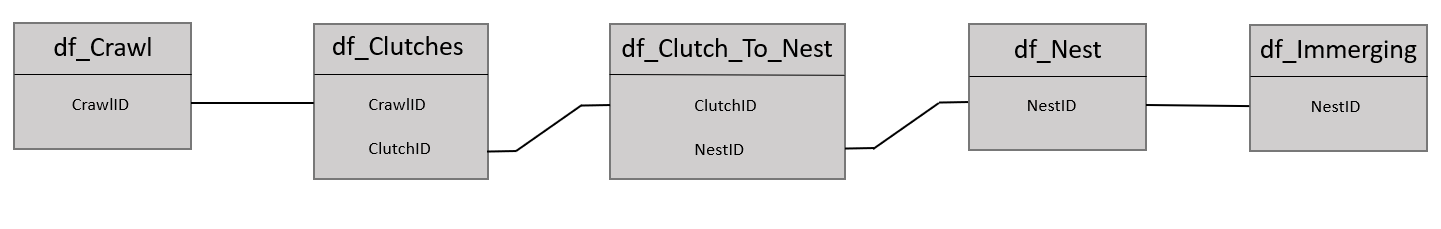


In [10]:
##inspect data
# df_Crawl_Specie_Location_Contacts.columns ## which columns there are
# df_Crawl.Nest.unique() ## what values this col contains


# are there *Clutches* connected to same *Crawls*?:

print(df_Clutches.duplicated(subset='CrawlID').sum()) ###duplications of crawl ids in clutches df

# if not df_Clutches.shape[0]==df_Clutches.CrawlID.nunique():
#     print(df_Clutches.shape[0])
#     print(df_Clutches.CrawlID.nunique())


40


It means that few CrawlIDs appear few times -meaning that *few clutches have the same Crawl ID*.

or anther way to put is- few cases where one Crawl is connected to few Clutches. 

#### visually inspecting duplicates in clutches and nests

I'll investigate these clutches - are they similar or identical? or are there any differences?
Is there any important data in these clutches that I should keep?

In [16]:
## all rows with same CrawlID:
df_Clutches.loc[df_Clutches.CrawlID.duplicated(keep=False)].sort_values('CrawlID').drop(['CollectingDate','RelocationDate' ],axis=1)  ##dropping sensitive data



,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectionHour,CollectorID,RelocationHour,RelocatorID,WasRelocated
1312,1807,5072,94.0,36.0,60.0,22.0,26.0,0.0,Not preyed,0.0,1899-12-30 08:30:00,331.0,1899-12-30 09:00:00,331.0,True
1400,1975,5072,94.0,36.0,60.0,22.0,26.0,0.0,Not preyed,0.0,1899-12-30 08:30:00,NaN,1899-12-30 09:00:00,NaN,True
1343,1838,5103,116.0,20.0,52.0,25.0,12.0,5.0,Not preyed,0.0,1899-12-30 15:00:00,NaN,1899-12-30 17:00:00,NaN,True
1401,2062,5103,116.0,20.0,52.0,25.0,12.0,5.0,Not preyed,0.0,1899-12-30 15:00:00,NaN,1899-12-30 17:00:00,NaN,True
1963,3231,161696,120.0,31.0,51.0,23.0,0.0,0.0,Not prayed,0.0,1899-12-30 07:00:00,211.0,1899-12-30 09:00:00,211.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2978,161720,84.0,36.0,53.0,22.0,33.0,0.0,Not prayed,0.0,1899-12-30 07:40:00,487.0,1899-12-30 08:30:00,NaN,True
1836,3006,161750,78.0,40.0,56.0,24.0,16.0,0.0,Not prayed,0.0,1899-12-30 07:30:00,250.0,1899-12-30 10:00:00,250.0,True
1835,3005,161750,78.0,40.0,56.0,24.0,16.0,0.0,Not prayed,0.0,1899-12-30 07:30:00,250.0,1899-12-30 10:00:00,250.0,True
1962,3195,162103,91.0,35.0,50.0,20.0,15.0,0.0,Not prayed,0.0,1899-12-30 08:30:00,237.0,1899-12-30 09:30:00,237.0,True


clutches seems indeed identical (except for less important of data of RelocatorID in clutchid=1807).

I'll check if theses clutches are leading to the same nests - if they do - then I can disgard them.

In [17]:
duplicated_clutches_crawlids=np.unique(df_Clutches.loc[df_Clutches.CrawlID.duplicated()]['CrawlID'].values)

for crawlid in duplicated_clutches_crawlids:
    crawl= df_Crawl.loc[df_Crawl.CrawlID==crawlid]
    clutches = df_Clutches.loc[df_Clutches.CrawlID==crawlid]
    clutchids= clutches['ClutchID'].values
    print('crawlid : ', crawl['CrawlID'].values,)

    for clutchid in clutchids:
        nestids=df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]['NestID'].values
        print('clutch id: ', clutchid,'\t' 'nestids: ',nestids)
    print('\n')    


crawlid :  [5072]
clutch id:  1807 	nestids:  [2598]
clutch id:  1975 	nestids:  []


crawlid :  [5103]
clutch id:  1838 	nestids:  [2628 2630]
clutch id:  2062 	nestids:  []


crawlid :  [161696]
clutch id:  2961 	nestids:  [3498 3615 3774]
clutch id:  3051 	nestids:  [3498 3615 3774]
clutch id:  3231 	nestids:  [3498 3774 3615]


crawlid :  [161698]
clutch id:  2962 	nestids:  [3500 3617 3776]
clutch id:  3052 	nestids:  [3500 3617 3776]
clutch id:  3232 	nestids:  [3500 3776 3617]


crawlid :  [161700]
clutch id:  2963 	nestids:  [3518 3673 3832]
clutch id:  3053 	nestids:  [3518 3673 3832]
clutch id:  3233 	nestids:  [3518 3673 3832]


crawlid :  [161701]
clutch id:  2964 	nestids:  [3502 3619 3778]
clutch id:  3054 	nestids:  [3502 3619 3778]
clutch id:  3234 	nestids:  [3502 3778 3619]


crawlid :  [161702]
clutch id:  2965 	nestids:  [3519 3674 3833]
clutch id:  3055 	nestids:  [3519 3674 3833]
clutch id:  3235 	nestids:  [3519 3674 3833]


crawlid :  [161703]
clutch id:  2966 	

Each crawl leads to 3 clutches - and each of them is leading to the same 2-3 nests!


Except for crawl_ids: 5103, 5072 - where I should keep clutches 1838 and 1807, and remove clutches 2062 and 1975.

So I can remove duplications in Clutches database, except for clutches 1838 and 1807 - I need to keep them (or add the connection to nest in the second one)




In [18]:
df_Clutches_without_duplicates=df_Clutches.drop_duplicates(subset='CrawlID',keep='first') 

## making sure that clutches 1838 and 1807 are kept
for clutchid in [1838,1807]:
    print(clutchid in df_Clutches_without_duplicates['ClutchID'])


True
True


In [19]:
# --- reassigning to original clutches df ---
print(df_Clutches.shape)

df_Clutches = df_Clutches_without_duplicates
print(df_Clutches.shape)


(2176, 17)
(2136, 17)


In [20]:
print(df_Nest.duplicated().sum())


0


In df_Crawls - it's noted if there's a nest or not in column 'Nest'


In [24]:
df_Crawl.loc[df_Crawl.Nest==False].drop(['CrawlDate','North','East','Location'],axis=1)  ##dropping sensitive data


,CrawlID,SerialNo,Nest,ListingDate,OnlyYear,DescriptionOfCrawl,SpecieID,NumOfDigs,TrackMin,TrackMax,...,contacts_ids,predation,Fox,Dog,Man,unknown,crab,Crow,Cat,Crab
31,33,7.0,False,NaT,False,None,2.0,4.0,NaN,75.0,...,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,34,8.0,False,NaT,False,None,2.0,5.0,NaN,75.0,...,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,36,12.0,False,NaT,False,None,2.0,1.0,NaN,88.0,...,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,37,14.0,False,NaT,False,כפר גלים,2.0,0.0,NaN,86.0,...,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,38,18.0,False,NaT,False,None,2.0,1.0,NaN,62.0,...,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4137,162427,NaN,False,NaT,False,None,2.0,NaN,70.0,70.0,...,494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4138,162428,NaN,False,NaT,False,None,2.0,NaN,70.0,70.0,...,494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4139,162429,NaN,False,NaT,False,None,8.0,NaN,NaN,NaN,...,836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4140,162430,NaN,False,NaT,False,None,8.0,1.0,80.0,80.0,...,836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


are all these crawls indeed lead to no clutch?

In df_Clutches:
If there's a nest - it is noted if the nest was relocated or not in column 'WasRelocated'.

Are there crawls without nest that was found in the clutches tabke and also noted as relocated?

In [25]:
crawls_without_nest=df_Crawl.loc[df_Crawl.Nest==False]['CrawlID'].values

crawls_without_nests_and_relocated = df_Clutches[df_Clutches.CrawlID.isin(crawls_without_nest)& df_Clutches.WasRelocated==True]
crawls_without_nests_and_relocated

,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectingDate,CollectionHour,CollectorID,RelocationDate,RelocationHour,RelocatorID,WasRelocated
977,989,4060,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,2007-06-24,NaT,NaN,NaT,NaT,NaN,True
1455,2143,5607,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1457,2145,5609,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1462,2150,5614,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1463,2151,5615,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1464,2152,5616,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1465,2153,5617,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1467,2155,5619,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1471,2159,5623,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True
1515,2203,5674,NaN,NaN,NaN,NaN,NaN,NaN,Not preyed,0.0,NaT,NaT,NaN,NaT,NaT,NaN,True


It seems that there are clutches that were relocated!
To make sure - I'll check if they are really appearing in the clutchtonest table

In [26]:
clutchids= crawls_without_nests_and_relocated['ClutchID'].values

df_ClutchToNest.loc[df_ClutchToNest.ClutchID.isin(clutchids)].shape

(0, 4)

They don't lead to a nest - meaning that there is no nest even if we fount them in the clutches table. 

In [27]:
df_Clutches

,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectingDate,CollectionHour,CollectorID,RelocationDate,RelocationHour,RelocatorID,WasRelocated
0,1,195,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,NaT,NaT,NaN,NaT,NaT,NaN,False
1,2,196,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,NaT,NaT,NaN,NaT,NaT,NaN,False
2,3,197,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,NaT,NaT,NaN,NaT,NaT,NaN,False
3,4,198,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,NaT,NaT,NaN,NaT,NaT,NaN,False
4,5,199,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,NaT,NaT,NaN,NaT,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171,3440,162485,77.0,35.0,48.0,17.0,19.0,NaN,Not preyed,0.0,2015-07-04,1899-12-30 09:00:00,1024.0,2015-07-04,1899-12-30 12:15:00,1024.0,False
2172,3441,162486,72.0,30.0,49.0,14.0,19.0,1.0,Not preyed,0.0,2015-07-04,1899-12-30 07:50:00,1024.0,2015-07-04,1899-12-30 13:00:00,1024.0,True
2173,3442,162487,72.0,30.0,49.0,14.0,15.0,1.0,Not preyed,0.0,2015-07-04,1899-12-30 07:50:00,1024.0,2015-07-04,1899-12-30 13:00:00,1024.0,True
2174,3443,162488,65.0,35.0,52.0,22.0,15.0,0.0,Not preyed,0.0,2015-07-13,1899-12-30 07:00:00,397.0,2015-07-13,1899-12-30 09:00:00,397.0,False


In [28]:
### inspect Nests df. are there nests that are not unique?
print(df_Nest.NestID.nunique(), df_Nest.shape)

2266 (2266, 16)


In [29]:
### inspect Clutch-to-Nests df. are there clutches that point to the same nest? 
print(df_ClutchToNest.NestID.nunique(), df_ClutchToNest.shape)


2111 (2283, 4)


In [30]:
df_ClutchToNest.NestID.duplicated().sum()

172

In [31]:
df_ClutchToNest[df_ClutchToNest.NestID.duplicated(keep=False)].sort_values('NestID')

,ClutchToNestID,ClutchID,NestID,EggsRelocated
1139,1287,1526,2379,48.0
1140,1288,1529,2379,27.0
1200,1348,1534,2440,69.0
1251,1404,1535,2440,34.0
1208,1357,1565,2449,69.0
...,...,...,...,...
2121,3515,2971,3836,71.0
2122,3516,3061,3836,71.0
2143,3559,3293,3845,91.0
2142,3558,3294,3845,91.0


In [34]:
nestids= set(df_ClutchToNest[df_ClutchToNest.NestID.duplicated(keep=False)]['NestID'])
df_Nest[df_Nest.NestID.isin(nestids)].sort_values('NestID').drop(['OpeningDate','NestAddingDate'], axis=1) ##dropping sensitive data




,NestID,HatcheryNestNo,HatcheryID,HatchingDate,OpeningHour,OpenerID,OpeningNotes,EmptyShells,LiveInNest,DeadInNest,DeadInEggs,UndevelopedEggs,NestOwner,NestOwnerCode
1105,2379,12,2.0,NaT,1899-12-30 18:15:00,260.0,None,51.0,0.0,3.0,0.0,20.0,NaN,NaN
1165,2440,10,4.0,NaT,1899-12-30 19:30:00,385.0,None,57.0,1.0,8.0,13.0,26.0,NaN,NaN
1173,2449,18,4.0,NaT,1899-12-30 21:45:00,385.0,None,33.0,2.0,0.0,9.0,35.0,NaN,NaN
1221,2498,23,8.0,NaT,1899-12-30 16:30:00,331.0,None,66.0,2.0,0.0,0.0,3.0,NaN,NaN
1372,2659,18,4.0,NaT,1899-12-30 20:00:00,395.0,None,87.0,NaN,NaN,NaN,7.0,5.0,2626.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,3833,11,8.0,NaT,NaT,NaN,None,NaN,4.0,1.0,1.0,NaN,7.0,2798.0
2021,3834,18,8.0,NaT,NaT,NaN,None,72.0,NaN,NaN,NaN,8.0,7.0,2805.0
2022,3835,19,8.0,NaT,1899-12-30 18:30:00,NaN,None,40.0,0.0,2.0,5.0,18.0,7.0,2806.0
2023,3836,22,8.0,NaT,1899-12-30 18:30:00,NaN,None,65.0,3.0,0.0,1.0,5.0,7.0,2811.0


In [36]:
clutchids= set(df_ClutchToNest[df_ClutchToNest.NestID.duplicated(keep=False)]['ClutchID'])
df_Clutches.loc[df_Clutches.ClutchID.isin(clutchids)].sort_values('ClutchID').drop(['CollectingDate','RelocationDate'],axis=1) ##dropping sensitive data

# for clutchid in clutchids:
#     nestids=df_ClutchToNest.loc[df_ClutchToNest.ClutchID==clutchid]['NestID'].values
#     print('clutch id: ', clutchid,'\t' 'nestids: ',nestids)
# print('\n') 

,ClutchID,CrawlID,EggsNo,DeptTopEgg,DepthBottomEgg,NestDiameter,NestDistance,BrokenOnRelocation,Predation,PreyedEggs,CollectionHour,CollectorID,RelocationHour,RelocatorID,WasRelocated
1103,1526,4702,53.0,35.0,47.0,15.0,NaN,0.0,Partially preyed,5.0,1899-12-30 06:00:00,260.0,1899-12-30 07:30:00,260.0,True
1106,1529,4705,27.0,25.0,35.0,15.0,NaN,0.0,Not preyed,0.0,1899-12-30 10:30:00,260.0,1899-12-30 11:30:00,260.0,True
1111,1534,4710,69.0,23.0,47.0,18.0,NaN,NaN,Not preyed,0.0,1899-12-30 07:30:00,320.0,1899-12-30 10:00:00,320.0,True
1112,1535,4711,54.0,30.0,44.0,NaN,NaN,NaN,Partially preyed,20.0,1899-12-30 05:45:00,320.0,1899-12-30 10:00:00,320.0,True
1140,1563,4739,NaN,40.0,50.0,19.0,NaN,NaN,Partially preyed,NaN,1899-12-30 09:00:00,228.0,1899-12-30 10:30:00,228.0,True
1142,1565,4741,69.0,30.0,50.0,20.0,NaN,NaN,Not preyed,0.0,1899-12-30 08:15:00,345.0,1899-12-30 10:00:00,345.0,True
1194,1618,4794,58.0,NaN,NaN,NaN,NaN,NaN,Partially preyed,50.0,NaT,331.0,1899-12-30 07:30:00,331.0,True
1195,1619,4795,61.0,38.0,58.0,19.0,18.0,NaN,Not preyed,0.0,1899-12-30 07:00:00,331.0,1899-12-30 07:30:00,331.0,True
1364,1859,5261,93.0,15.0,48.0,20.0,16.0,2.0,Not preyed,0.0,1899-12-30 06:30:00,385.0,1899-12-30 10:00:00,385.0,True
1365,1860,5262,NaN,NaN,NaN,NaN,NaN,NaN,Partially preyed,NaN,1899-12-30 03:00:00,385.0,1899-12-30 10:00:00,385.0,True


it seems that clutches that was removed from Clutches table - still apears in the Nests table, even if not leading to any data because not asked..
it should be removed/noted as irelevant data.


In [37]:
# clutchids=df_Clutches.loc[df_Clutches.CrawlID.isin(duplicated_clutches_crawlids)]['ClutchID'].values
# print(clutchids)
deleted_crawlids = duplicated_clutches_crawlids

unique_clutchids = df_Clutches['ClutchID'].values

for clutchid in deleted_crawlids:
    if clutchid in unique_clutchids:
        np.delete(deleted_crawlids, np.argwhere(deleted_crawlids == clutchid))
        
print(clutchids)
print(deleted_crawlids)        
print(duplicated_clutches_crawlids)




{1529, 1563, 1565, 3064, 1618, 1619, 3195, 2178, 2179, 2207, 3231, 3232, 3234, 3233, 3236, 3237, 3235, 3238, 3240, 3239, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3241, 3250, 3251, 3252, 2229, 3253, 3255, 3256, 3254, 3257, 3259, 3258, 3261, 3262, 3263, 3264, 3260, 3290, 3291, 3292, 3293, 3294, 1859, 1860, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 3005, 3006, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 1526, 3063, 3062, 3065, 3066, 3067, 3068, 1534, 1535}
[  5072   5103 161696 161698 161700 161701 161702 161703 161704 161706
 161707 161708 161710 161714 161715 161716 161717 161718 161719 161720
 161750 162103]
[  5072   5103 161696 161698 161700 161701 161702 161703 161704 161706
 161707 161708 161710 161714 161715 161716 161717 161718 161719 161720
 161750 162103]
